### Notebook to do inference on a new image

In [28]:
# Load
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
import numpy as np
from scipy.ndimage import zoom
from src.data.dataset import Dataset
from src.modules.lightning_cnn import LitCNN
from src.utils.optimization import Optimization
import nibabel as nib
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt


MODEL_PATH = r"/home/ubuntu/giorgio/v311/lightning_logs/brain_model/version_111/checkpoints/epoch=29-step=180.ckpt"
IMG_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/goundtruth_testBosisio/goundtruth/sub-134_dseg_warped_0.5mm.nii.gz"
MRI_PATH = r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/MRI_testBosisio/images/sub-134_brain_warped_0.5mm.nii.gz"

def resize(array: np.array,) :
    target_shape = (128, 128, 128)

    # Calculate zoom factors
    original_shape = array.shape
    zoom_factors = [t / o for t, o in zip(target_shape, original_shape)]

    # Resize the array using nearest-neighbor interpolation
    resized_array = zoom(array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation
    return resized_array

def reshape_output(
    y_hat: torch.Tensor,
) -> torch.Tensor:
    """
    Reshape the output tensor (1,30) of the model to the (10,3) model.

    Parameters:
    - y_hat (torch.Tensor): Predicted tensor (1,30) from the model.

    Returns:
    - torch.Tensor: output tensor with resized shape.

    """
    y_hat_new = y_hat.cpu().data.numpy()
    y_hat_new = y_hat_new.reshape(10,3)

    return y_hat_new

In [29]:
def import_img(IMG_PATH:str, MRI_PATH:str):
    raw_img = nib.load(IMG_PATH)
    my_img = raw_img.get_fdata()
    raw_MRI = nib.load(MRI_PATH)
    my_MRI = raw_MRI.get_fdata()
    resized_img = resize(my_img)
    resized_MRI = resize(my_MRI)
    resized_img=np.expand_dims(resized_img, axis=0)
    resized_img=np.expand_dims(resized_img, axis=0)
    # Verify the result
    print(resized_img.shape)
    return resized_img, resized_MRI

resized_img, resized_MRI = import_img(IMG_PATH, MRI_PATH) 

(brains,
    y_reg,
    predict_index,
) = tuple(
    map(
        torch.Tensor,
        (
            resized_img,
            [np.ones(30)],
            1,
        ),
    )
)
pred_dataset = TensorDataset(
    brains,
    y_reg,
    predict_index,
)

dataset = pred_dataset
lightning_cnn = LitCNN.load_from_checkpoint(checkpoint_path=MODEL_PATH)

prediction_loader = DataLoader(
    dataset,
    num_workers=0,
)

trainer = Trainer(logger=False)

biometry=trainer.predict(lightning_cnn, dataloaders=prediction_loader, return_predictions=True)
biometry=reshape_output(biometry[0])
old_bio=biometry

(1, 1, 128, 128, 128)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ubuntu/giorgio/v311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.08it/s]


In [30]:
biometry

array([[ 63.747078,  89.22044 ,  67.18586 ],
       [ 63.83636 ,  58.662495,  68.41557 ],
       [ 61.87669 ,  39.379795,  29.207516],
       [ 62.30527 ,  41.253525,  47.587315],
       [108.908875,  57.066074,  71.6588  ],
       [ 17.169485,  56.677094,  69.754135],
       [  7.520544,  67.15088 ,  68.13854 ],
       [119.422195,  64.477715,  65.279884],
       [ 81.997856,  40.779045,  32.414608],
       [ 44.11704 ,  40.610905,  31.822039]], dtype=float32)

### Per visualizzare i risultati

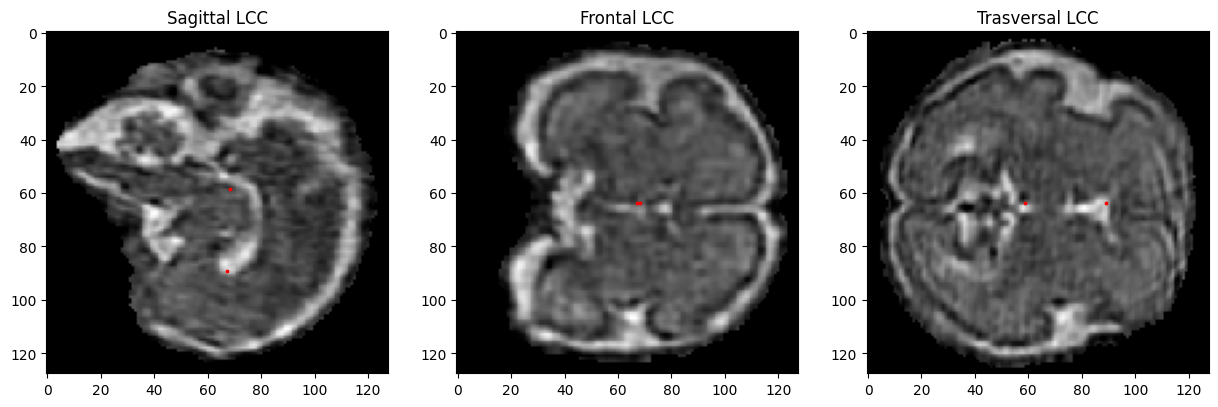

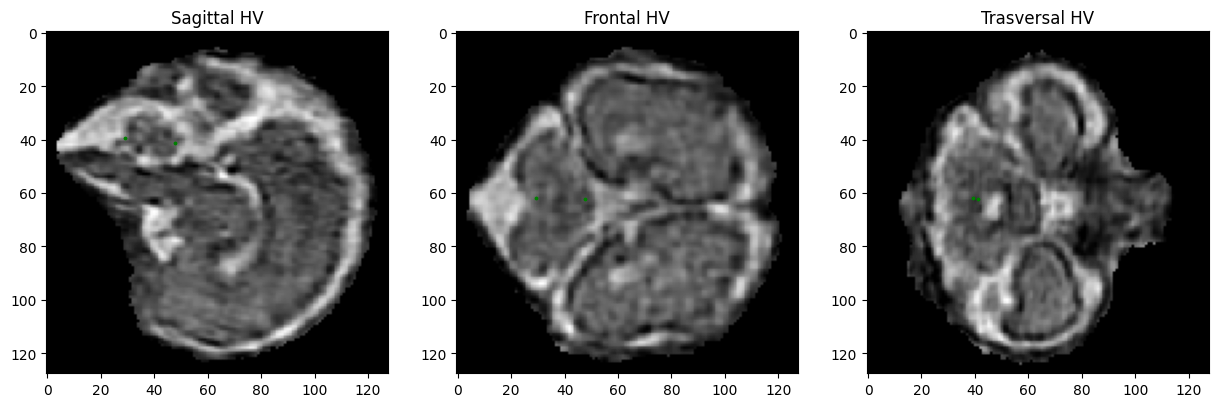

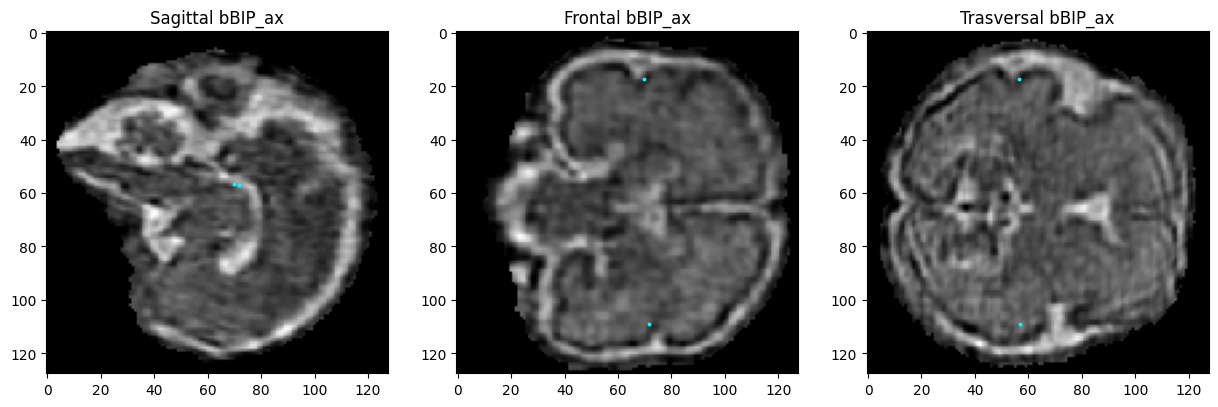

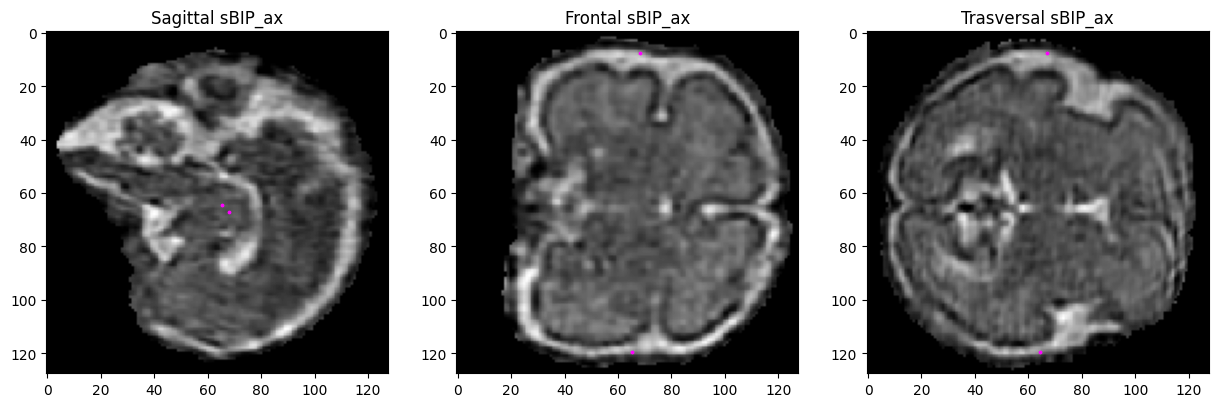

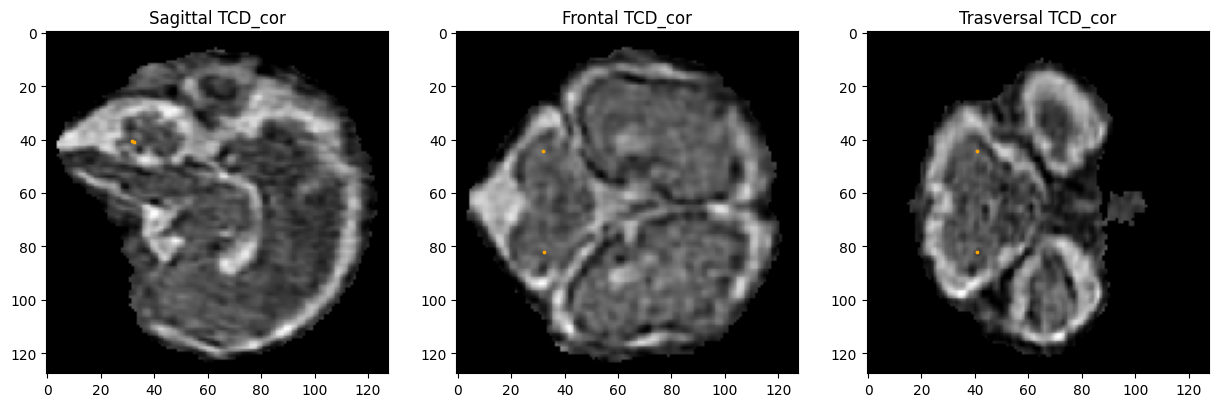

In [31]:
import matplotlib.pyplot as plt

x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_MRI

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

### Fase di ottimizzazione

/home/ubuntu/giorgio/v311/FeTa_challenge_2024/src/utils/optimization.py:61: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.

/home/ubuntu/giorgio/v311/FeTa_challenge_2024/src/utils/optimization.py:55: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



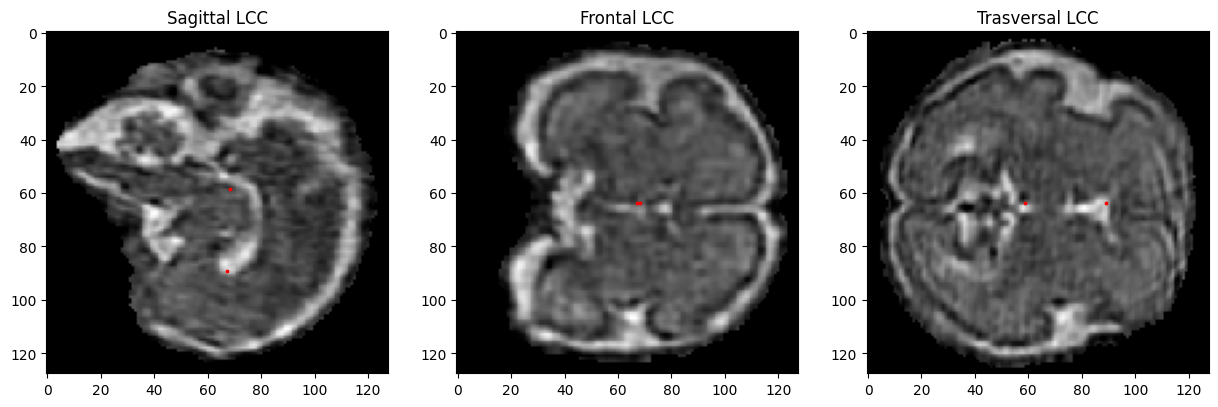

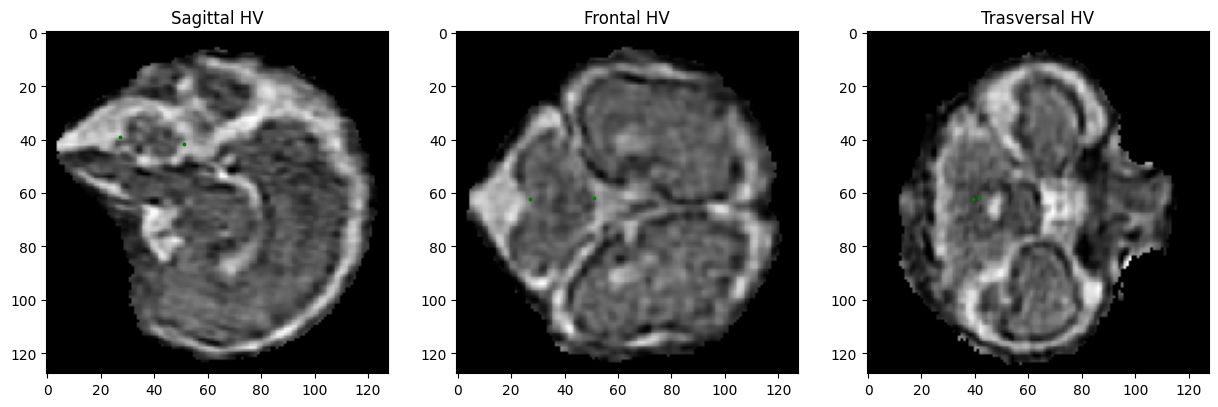

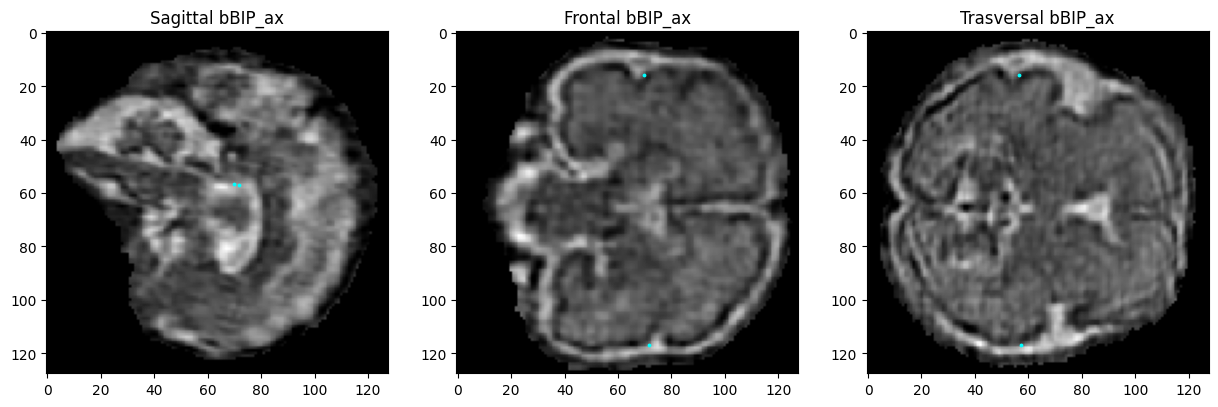

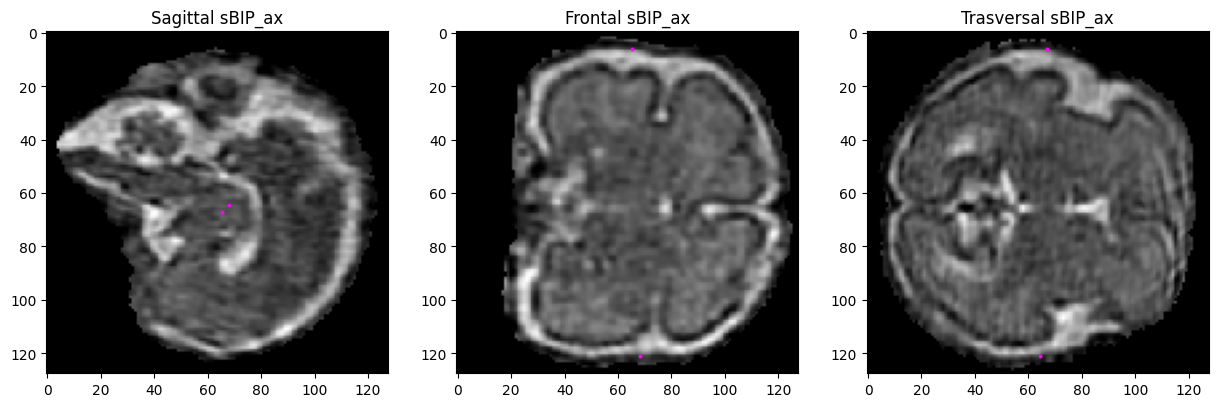

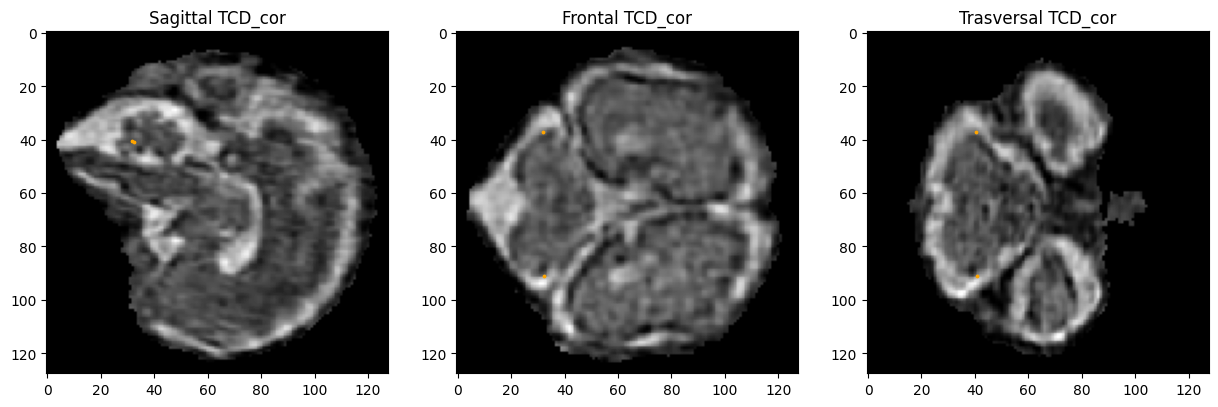

In [32]:
import matplotlib.pyplot as plt

opti= Optimization(resized_img, resized_MRI, biometry,)
opti.optimize()
biometry=opti.biometry
x_positions, y_positions, z_positions = biometry[:,0],biometry[:,1],biometry[:,2]
visualize=resized_img[0][0]
visualize=resized_MRI

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

TO DO


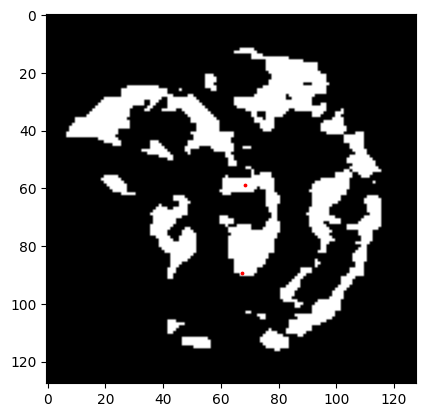

In [33]:
opti.segment_LCC()
opti.optimize_LCC()

### Testing

In [34]:
raw_img = nib.load(r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_rec-nmic_T2w.nii.gz")
my_img = raw_img.get_fdata()

In [35]:
def reconstruct_sparse_matrix(coordinates_and_values, num_x=176, num_y=224, num_z=176):
    # Initialize a 3D matrix with zeros
    sparse_matrix = np.zeros((num_x, num_y, num_z))
    
    # Populate the matrix using the coordinates_and_values array
    for coord in coordinates_and_values:
        x, y, z, value = coord
        sparse_matrix[int(x), int(y), int(z)] = value
    
    return sparse_matrix

In [36]:
def inverse_resize(resized_array: np.array, keypoints: np.array, original_shape=(176,224,176)):
    # Calculate the inverse zoom factors
    zoom_factors = [o / t for t, o in zip(resized_array.shape, original_shape)]

    # Resize the array back to the original shape using nearest-neighbor interpolation
    original_array = zoom(resized_array, zoom_factors, order=0)  # 'order=0' for nearest-neighbor interpolation

    transformed_keypoints = np.array([(int(x * zoom_factors[0]), int(y * zoom_factors[1]), int(z * zoom_factors[2])) for x, y, z in keypoints])
    
    return original_array, transformed_keypoints

In [37]:
gerry_img = nib.load(IMG_PATH)
scotti_img = gerry_img.get_fdata()
gerry_matrix=gerry_img.affine

In [38]:
scotti_img.shape

(176, 224, 176)

In [39]:
data_orig, bio_orig=inverse_resize(resized_img[0][0], biometry)

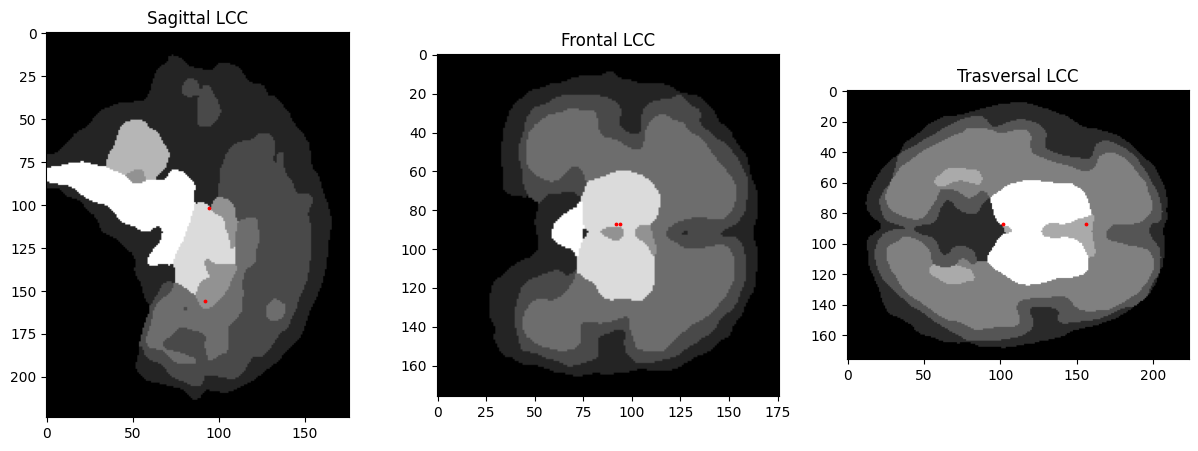

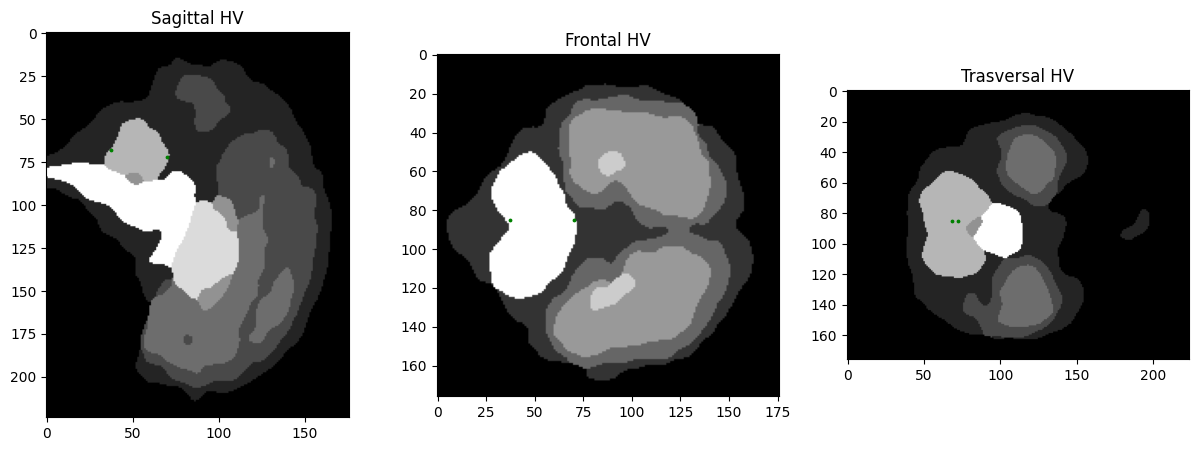

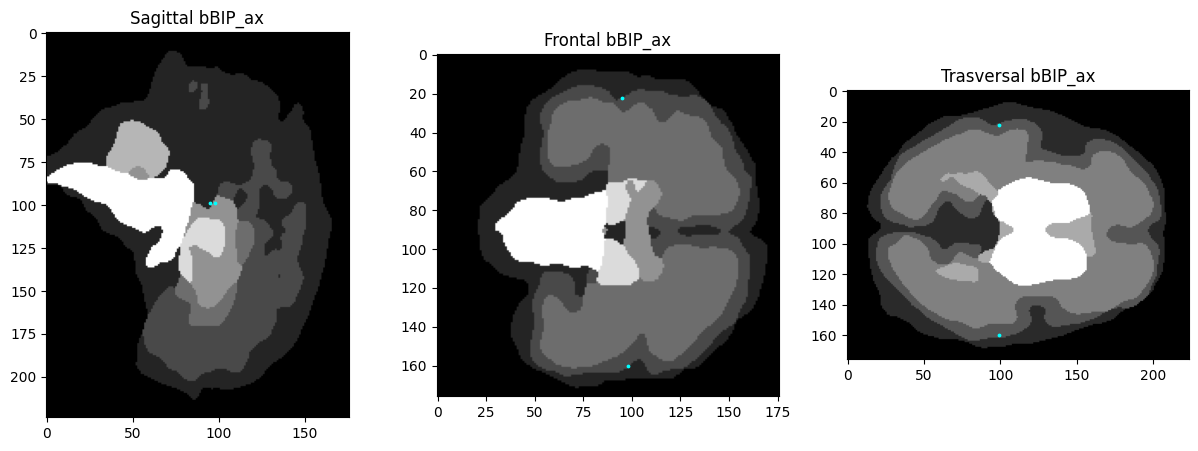

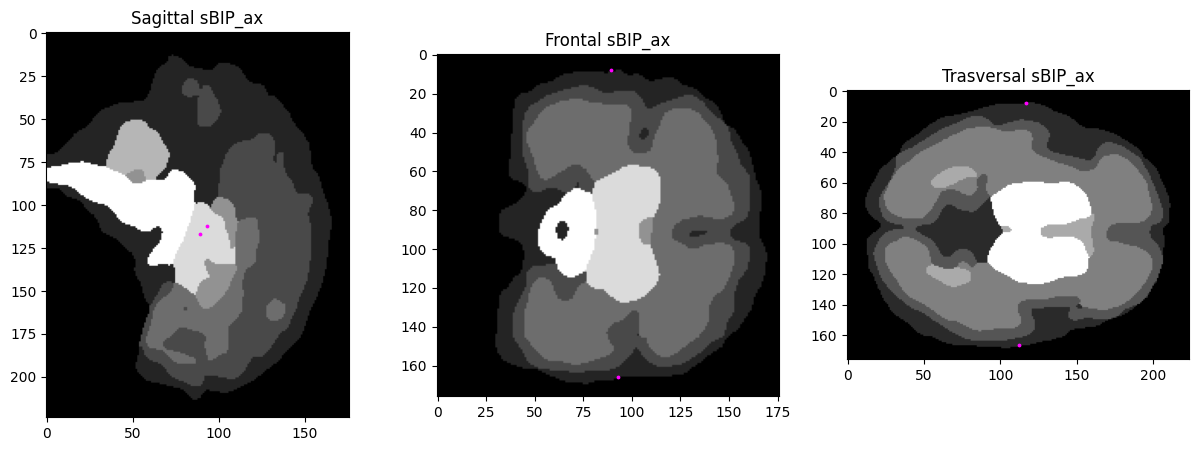

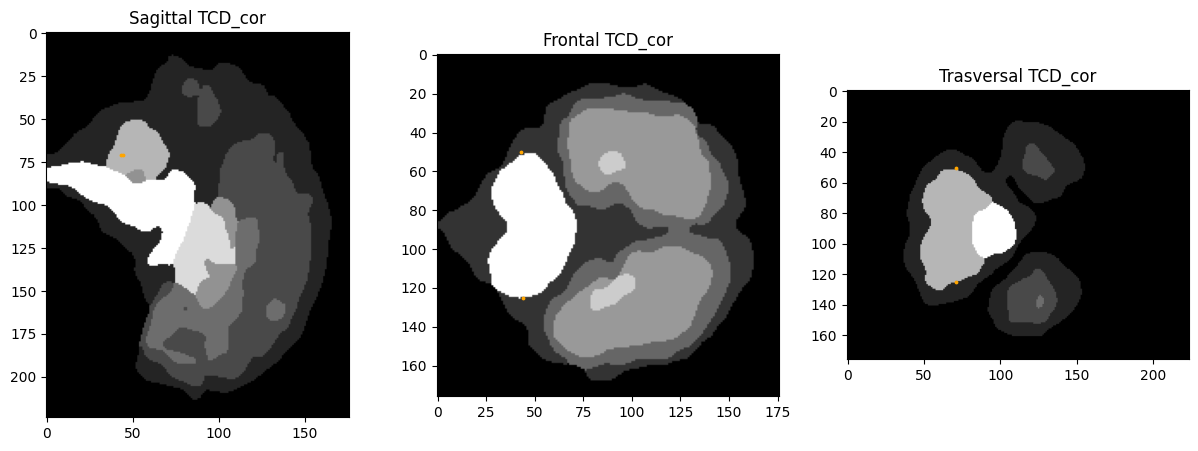

In [40]:
import matplotlib.pyplot as plt
x_positions, y_positions, z_positions = bio_orig[:,0],bio_orig[:,1],bio_orig[:,2]
visualize=scotti_img
#visualize=my_img

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

In [41]:
import ants
import nibabel as nib
values=np.array([1,1,2,2,3,3,4,4,5,5])
bio_val=np.column_stack((bio_orig, values))
a=reconstruct_sparse_matrix(bio_val)
output=r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_bio.nii.gz"

# Create a NIfTI i  mage
img = nib.Nifti1Image(a, affine=gerry_matrix)

nib.save(img, output)
#ants.image_write(a, output)

In [42]:
import ants
fixed = ants.image_read(r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_rec-nmic_T2w.nii.gz")
moving = ants.image_read( r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_bio.nii.gz")
mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving, transformlist= r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/0GenericAffine_134.mat", interpolator="nearestNeighbor",
                                      whichtoinvert=[True], singleprecision=True,
                                      )
output=r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_gerry_bio.nii.gz"
ants.image_write(mywarpedimage, output)

In [43]:
carlo_img = nib.load(r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_gerry_bio.nii.gz")
conti_img = raw_img.get_fdata()

In [44]:
def load_biometry(path) -> np.array:
    bio=[]
    my_img = nib.load(path)
    nii_data = my_img.get_fdata()
    non_zero_positions = np.nonzero(nii_data)
    values = nii_data[non_zero_positions]
    x_positions, y_positions, z_positions = non_zero_positions
    coordinates_and_values = np.column_stack((x_positions, y_positions, z_positions, values))
    coordinates_and_values = coordinates_and_values[coordinates_and_values[:, -1].argsort()]
    bio.append(coordinates_and_values)
    return np.array(bio[0])

In [90]:
import fsl.data.image as fslimage
from scipy import ndimage
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform

def biometry_transformer(fixed_path:str, moving_path:str, matrix_path:str, output_path:str ) -> None:
    
    image = fslimage.Image(moving_path)
    data = image.data

    # Define the structuring element for dilatation and perform the dilatation
    structuring_element = ndimage.generate_binary_structure(3, 3)
    dilated_data = ndimage.grey_dilation(data, footprint=structuring_element)

    dilated_image = fslimage.Image(dilated_data, header=image.header)
    dilated_image.save(output_path)

    fixed = ants.image_read(fixed_path)
    moving = ants.image_read( output_path)
    mywarpedimage = ants.apply_transforms(  fixed=fixed,
                                            moving=moving,
                                            transformlist= matrix_path,
                                            interpolator="nearestNeighbor",
                                            whichtoinvert=[True], 
                                            singleprecision=True,
                                            )
    
    ants.image_write(mywarpedimage, output_path)
    
def group_the_keypoints(array: np.array, threshold=3):
    def custom_distance(row1, row2):
        return np.linalg.norm(row1 - row2)  # Euclidean distance
    
    # Calculate the pairwise distance matrix
    distance_matrix = pdist(array, metric=custom_distance)
    
    # Convert the distance matrix to a square form
    square_distance_matrix = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    Z = linkage(square_distance_matrix, method='single')
    
    # Form clusters based on a threshold distance
    labels = fcluster(Z, t=threshold, criterion='distance')
    
    # Separate the rows into clusters
    cluster1 = array[labels == 1]
    cluster2 = array[labels == 2]
    
    # Calculate the averages of each cluster
    average_cluster1 = np.mean(cluster1, axis=0) if len(cluster1) > 0 else np.zeros(array.shape[1])
    average_cluster2 = np.mean(cluster2, axis=0) if len(cluster2) > 0 else np.zeros(array.shape[1])
    
    # Combine the averages into a single array
    label_1 = np.array([average_cluster1, average_cluster2])
    
    return label_1.astype(int)

In [97]:
import os
sub_id=134
base_path_1=r"/home/ubuntu/giorgio/v311/FeTa_challenge_2024"
f=  os.path.join(base_path_1, f'sub-{sub_id}_rec-nmic_T2w.nii.gz' )
m=  os.path.join(base_path_1, f'sub-{sub_id}_bio.nii.gz' )
mat=os.path.join(base_path_1, f'0GenericAffine_{sub_id}.mat')
biometry_transformer(f,m,mat,output)

In [98]:
testing_it = load_biometry("/home/ubuntu/giorgio/v311/FeTa_challenge_2024/sub-134_gerry_bio.nii.gz")

In [99]:
testing_it


[array([[118., 140., 119.,   1.],
        [127., 123., 125.,   1.],
        [129., 117., 151.,   2.],
        [129., 118., 151.,   2.],
        [130., 115., 138.,   2.],
        [130., 116., 138.,   2.],
        [106., 111., 127.,   3.],
        [105., 111., 127.,   3.],
        [152., 135., 122.,   3.],
        [152., 134., 122.,   3.],
        [ 97., 115., 128.,   4.],
        [ 98., 115., 128.,   4.],
        [ 98., 115., 127.,   4.],
        [152., 140., 122.,   4.],
        [117., 112., 150.,   5.],
        [117., 112., 149.,   5.],
        [142., 125., 147.,   5.]])]

In [94]:
trasformed_biometry= np.empty((0, 4), dtype=int)
for i in range(5):
    selected_rows = group_the_keypoints(testing_it[0][testing_it[0][:, 3] == i+1])
    trasformed_biometry=np.concatenate((trasformed_biometry, selected_rows), axis=0)

/tmp/ipykernel_978/854413412.py:43: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [95]:
trasformed_biometry

array([[118, 140, 119,   1],
       [127, 123, 125,   1],
       [129, 117, 151,   2],
       [130, 115, 138,   2],
       [152, 134, 122,   3],
       [105, 111, 127,   3],
       [ 97, 115, 127,   4],
       [152, 140, 122,   4],
       [117, 112, 149,   5],
       [142, 125, 147,   5]])

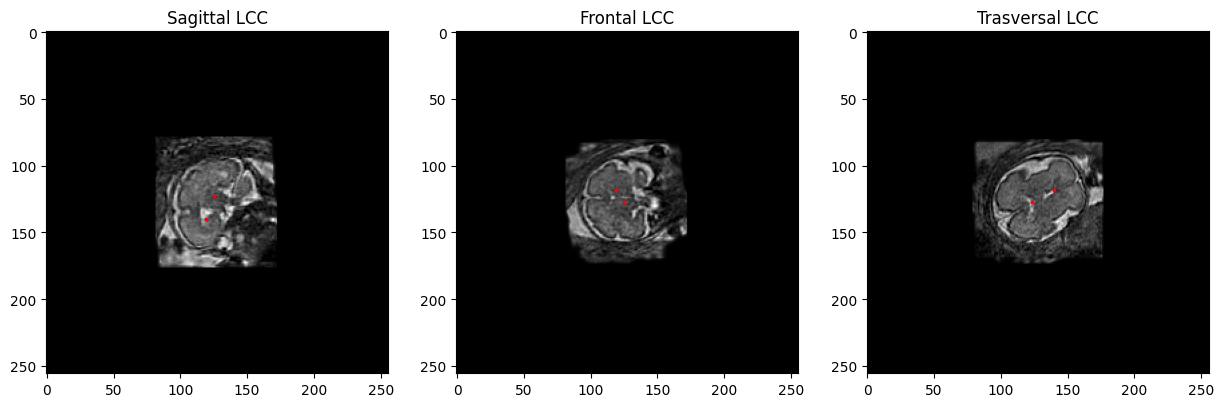

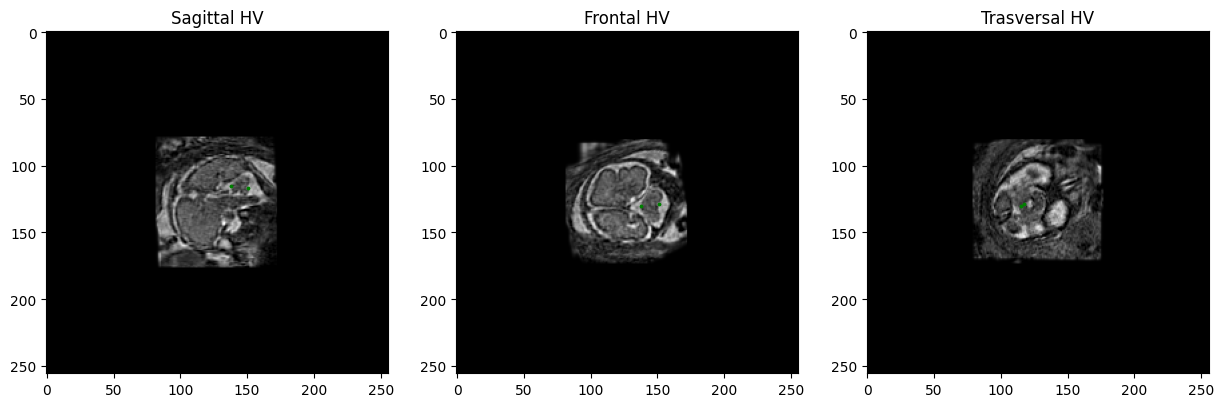

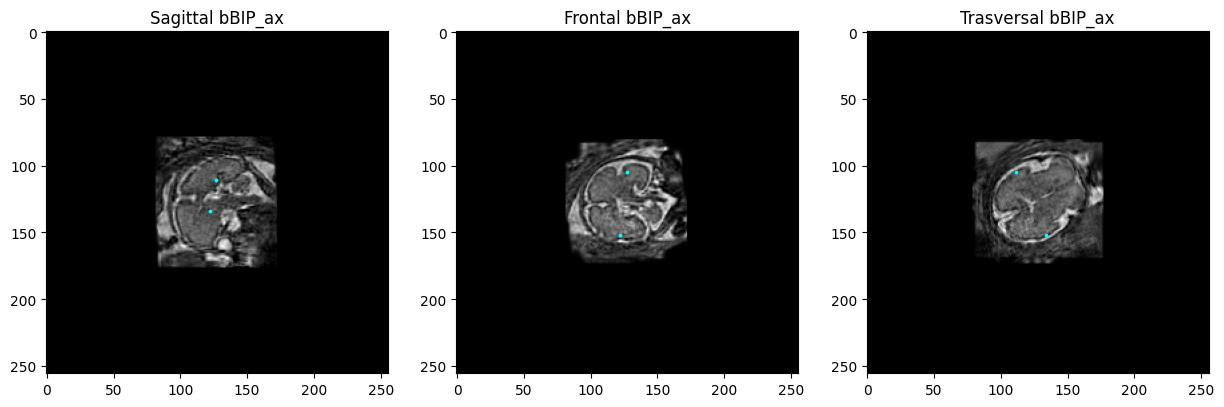

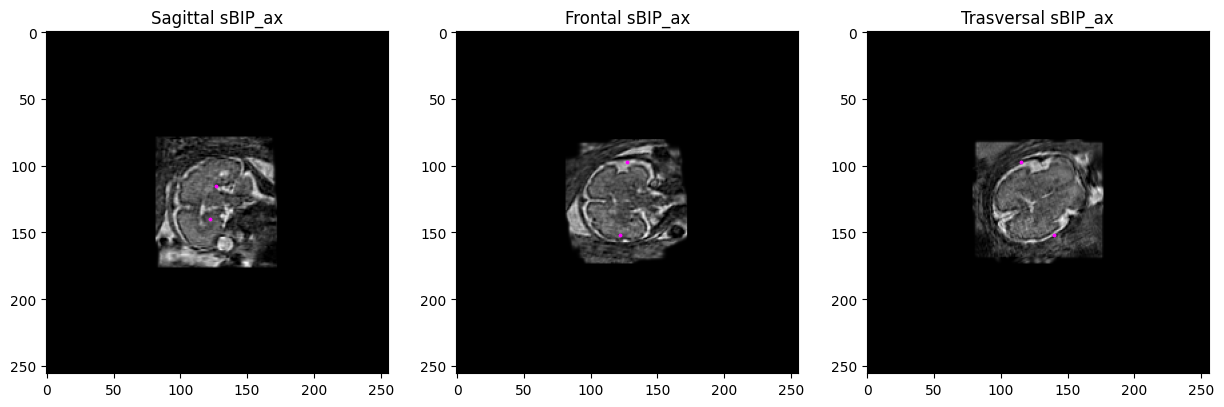

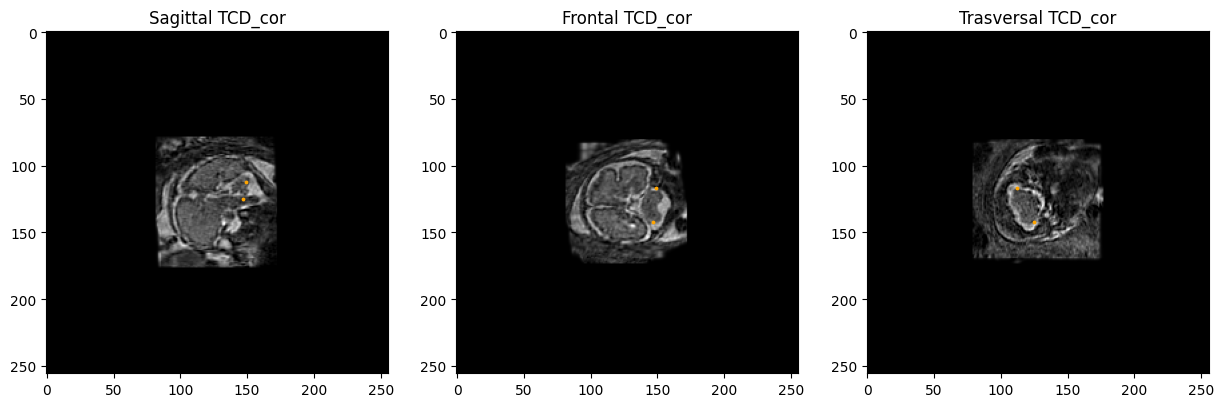

In [96]:
import matplotlib.pyplot as plt
testing_it=np.array(testing_it[0])
testing_it=trasformed_biometry
x_positions, y_positions, z_positions = testing_it[:,0],testing_it[:,1],testing_it[:,2]
visualize=resized_img[0][0]
visualize=my_img

color_dict = {
    0: 'red',
    1: 'green',
    2: 'cyan',
    3: 'magenta',
    4: 'orange'
}

bio_dict = {
    0: 'LCC',
    1: 'HV',
    2: 'bBIP_ax',
    3: 'sBIP_ax',
    4: 'TCD_cor'
}

# Display each image in a subplot
for i in range(5):
    #i=i+1
    organ=bio_dict[i]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(visualize[int((x_positions[2*i]+x_positions[2*i+1])/2),:,:],cmap='gray')
    axs[0].set_title(f'Sagittal {organ}')
    axs[0].scatter(z_positions[2*i],y_positions[2*i], c=color_dict[i], s=3)
    axs[0].scatter(z_positions[2*i+1],y_positions[2*i+1], c=color_dict[i], s=3)

    axs[1].imshow(visualize[:,int((y_positions[2*i]+y_positions[2*i+1])/2),:],cmap='gray')
    axs[1].set_title(f'Frontal {organ}')
    axs[1].scatter(z_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[1].scatter(z_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    axs[2].imshow(visualize[:,:,int((z_positions[2*i]+z_positions[2*i+1])/2)],cmap='gray')
    axs[2].set_title(f'Trasversal {organ}')
    axs[2].scatter(y_positions[2*i],x_positions[2*i], c=color_dict[i], s=3)
    axs[2].scatter(y_positions[2*i+1],x_positions[2*i+1], c=color_dict[i], s=3)

    # Display the plot
    plt.show()

In [ ]:
import SimpleITK as sitk

REGION_DICT = {
    "LCC": 1,
    "HV": 2,
    "bBIP": 3,
    "sBIP": 4,
    "TCD": 5,
    }

def get_dist(im, region):
    """
    Get the distance between the two points of a given region.
    """
    x, y, z = np.where(sitk.GetArrayFromImage(im) == REGION_DICT[region])
    if len(x) == 0:
        return np.nan
    p1 = np.array([x[0], y[0], z[0]])
    p2 = np.array([x[1], y[1], z[1]])
    ip_res = im.GetSpacing()[0]
    assert len(x) == 2, f"Region {region} has {len(x)} points"
    dist = round(np.linalg.norm((p1 - p2) * ip_res), 2)
    return dist